<a href="https://colab.research.google.com/github/anilkaushikwireless/email_wrapper/blob/master/Benchmarking_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis
> First we train the Convolutional Neural Network on 'training_20k.txt' or 'training_50k.txt'. The CNN model returns accuracy. After the training, a pickle file is saved of the model.
This pickle file is used to test the performance of model on unseen data.
> To run on augmented data change train file name.

* The difference between training and unseen data accuracy should be minimum. UNSEEN ACCURACY can be lower than training.

In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
import keras.layers as layers
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import pandas as pd
import math
import time
import numpy as np
import random
from random import randint
random.seed(3)
import datetime, re, operator
from random import shuffle
from time import gmtime, strftime
import gc
import joblib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #get rid of warnings
from os import listdir
from os.path import isfile, join, isdir
import pickle
import csv

Using TensorFlow backend.


In [0]:
#--------------------------------------------------
#--Globals------------------------------------------
num_classes=2
input_size=50
word2vec_len=300
percent_dataset=0.1
sentiment_analysis_path = 'benchmarks/data/sentiment_analysis/'
huge_word2vec = 'glove.840B.300d.txt'
train_file = os.path.join(sentiment_analysis_path,'training_20k.txt')
test_file = os.path.join(sentiment_analysis_path,'testing.txt')
unseen_data = os.path.join(sentiment_analysis_path,'unseen_original.csv')
unseen_test_csv = os.path.join(sentiment_analysis_path,'unseen_test.csv')
unseen_test_txt = os.path.join(sentiment_analysis_path,"unseen_test.txt")
#------------------------------------------------------
#---------------------------------------------------

In [0]:
def load_pickle(file):
    return pickle.load(open(file, 'rb'))

##### Download word2vec (File Size - 5.2GB)

In [4]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [0]:
import os
os.chdir("drive/My Drive/")
#!unzip 'benchmarks/notebooks/glove.840B.300d.zip'

In [0]:
def gen_vocab_dicts(output_pickle_path, huge_word2vec,train_file):

    vocab = set()
    text_embeddings = open(huge_word2vec, 'r').readlines()
    word2vec = {}
    try:
        all_lines = open(train_file, "r").readlines()
        for line in all_lines:
            words = line[:-1].split(' ')
            for word in words:
                vocab.add(word)
    except:
        print(txt_path, "has an error")
    
    print(len(vocab), "unique words found")

    # load the word embeddings, and only add the word to the dictionary if we need it
    for line in text_embeddings:
        items = line.split(' ')
        word = items[0]
        if word in vocab:
            vec = items[1:]
            word2vec[word] = np.asarray(vec, dtype = 'float32')
    print(len(word2vec), "matches between unique words and word2vec dictionary")
        
    pickle.dump(word2vec, open(output_pickle_path, 'wb'))
    print("dictionaries outputted to", output_pickle_path)

In [0]:
#gen_vocab_dicts('word2vec.p',huge_word2vec,train_file)

In [0]:
word2vec_pickle ='benchmarks/notebooks/word2vec.p'
word2vec = load_pickle(word2vec_pickle)

In [0]:
def run_cnn(train_file, test_file, num_classes, percent_dataset):
    
    #initialize model
    #model = build_cnn(input_size, word2vec_len, num_classes)
    
    #load data
    train_x, train_y = get_x_y(train_file, num_classes, word2vec_len, input_size, word2vec, percent_dataset)
    test_x, test_y = get_x_y(test_file, num_classes, word2vec_len, input_size, word2vec, 1)
    
    #implement early stopping
    #callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
    
    #train model
    model.fit(train_x, 
              train_y, 
              epochs=10000000, 
              callbacks=callbacks,
             validation_split=0.1, 
              batch_size=1024, 
              shuffle=True, 
              verbose=0)
    pickle.dump(model, open('benchmarks/models/trained_model.pkl', 'wb'))
    #evaluate model
    #print(type(test_x))
    #print(test_x)
    y_pred = model.predict(test_x)
    test_y_cat = one_hot_to_categorical(test_y)
    y_pred_cat = one_hot_to_categorical(y_pred)
    acc = accuracy_score(test_y_cat, y_pred_cat)
    #clean memory
    train_x, train_y, test_x, test_y, model = None, None, None, None, None
    gc.collect()
    
    #return the accuracy
    #print("data with shape:", train_x.shape, train_y.shape, 'train=', train_file, 'test=', test_file, 'with fraction', percent_dataset, 'had acc', acc
    return acc*100

### Convolutional Neural Network

In [0]:
def build_cnn(sentence_length, word2vec_len, num_classes):
    model = None
    model = Sequential()
    model.add(layers.Conv1D(128, 5, activation='relu', input_shape=(sentence_length, word2vec_len)))
    model.add(layers.GlobalMaxPooling1D())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','binary_accuracy','categorical_accuracy'])
    return model

In [0]:
def get_x_y(train_txt, num_classes, word2vec_len, input_size, word2vec, percent_dataset):
    
    #read in lines
    #print(train_txt)
    train_lines = open(train_txt, 'r').readlines()
    shuffle(train_lines)
    train_lines = train_lines[:int(percent_dataset*len(train_lines))]
    num_lines = len(train_lines)
    
    #initialize x and y matrix
    x_matrix = None
    y_matrix = None
    try:
        x_matrix = np.zeros((num_lines, input_size, word2vec_len))
    except:
        print("Error!", num_lines, input_size, word2vec_len)
    y_matrix = np.zeros((num_lines, num_classes))
    
    #insert values
    for i, line in enumerate(train_lines):
        parts = line[:-1].split('\t')
        label = int(parts[0])
        sentence = parts[1]
        
        #insert x
        words = sentence.split(' ')
        words = words[:x_matrix.shape[1]] #cut off if too long
        for j, word in enumerate(words):
            if word in word2vec:
                x_matrix[i, j, :] = word2vec[word]
        
        #insert y
        y_matrix[i][label] = 1.0
    return x_matrix, y_matrix

In [0]:
def one_hot_to_categorical(y):
    assert len(y.shape) == 2
    return np.argmax(y, axis=1)

In [0]:
#train_accuracy = run_cnn(train_file,test_file,num_classes,percent_dataset)

----

# Evaluating the Model


## Testing on unseen data

In [0]:
import csv
file = unseen_test_csv
file_name, file_ext = os.path.splitext(file)
with open(file,'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    newfile = unseen_test_txt

    for line in csv_reader:
        with open(newfile, 'a') as new_txt:    #new file has .txt extn
            txt_writer = csv.writer(new_txt, delimiter = '\t') #writefile
            txt_writer.writerow(line)  

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
test_x, test_y = get_x_y(unseen_test_txt, num_classes, word2vec_len, input_size, word2vec, .5)












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training Accuracy - 84 
 Unseen Data Accuracy - 82.78298800436204


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     51311
           1       0.83      1.00      0.91    246714

    accuracy                           0.83    298025
   macro avg       0.41      0.50      0.45    298025
weighted avg       0.69      0.83      0.75    298025

confusion matrix
[[     0  51311]
 [     0 246714]]


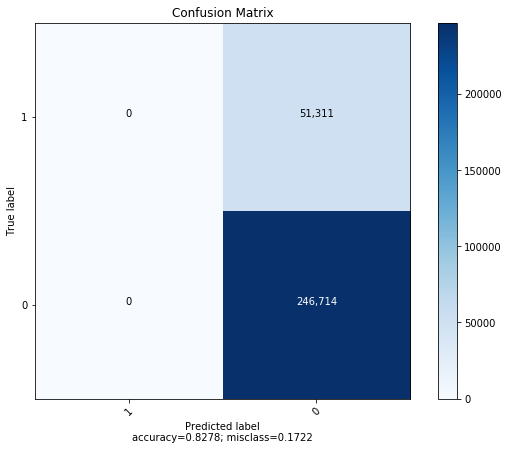

In [17]:
model=joblib.load('benchmarks/models/trained_model.pkl')
y_pred=model.predict(test_x)
test_y_cat = one_hot_to_categorical(test_y)
y_pred_cat = one_hot_to_categorical(y_pred)
unseenDataAccuracy = abs(accuracy_score(test_y_cat, y_pred_cat)*100)
print("Training Accuracy - {} \n Unseen Data Accuracy - {}".format("84",unseenDataAccuracy))
from sklearn.metrics import classification_report
print(classification_report(test_y_cat, y_pred_cat))
from sklearn.metrics import confusion_matrix
print("confusion matrix")
cmatrix=confusion_matrix(test_y_cat, y_pred_cat)
print(cmatrix)
plot_confusion_matrix(cmatrix, 
                      normalize    = False,
                      target_names = ['1', '0'],
                      title        = "Confusion Matrix")

          




